# pneumonia detection from chest x-rays  with transfer learning (mobilenetv2)

## dependencies


In [22]:
import os
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image
import random
import tensorflow as tf
from tensorflow.keras import Model

## dataset


In [2]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [3]:
!mv chest_xray/chest_xray /content/chest_xray_clean

In [4]:
!find /content/chest_xray_clean -name "__MACOSX" -exec rm -rf {} +
!find /content/chest_xray_clean -name ".DS_Store" -delete

In [5]:
!rm -rf /content/chest_xray

In [6]:
base = "/content/chest_xray_clean"
for split in ["train", "test", "val"]:
    split_dir = os.path.join(base, split)
    classes = [c for c in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, c))]
    counts = {c: len(os.listdir(os.path.join(split_dir, c))) for c in classes}
    print(split, counts)

train {'PNEUMONIA': 3875, 'NORMAL': 1341}
test {'PNEUMONIA': 390, 'NORMAL': 234}
val {'PNEUMONIA': 8, 'NORMAL': 8}


## exploration and preprocessing

In [7]:
import os

base = "/content/chest_xray_clean"
for split in ["train", "val", "test"]:
    print(f"\n{split}:")
    split_dir = os.path.join(base, split)
    for cls in os.listdir(split_dir):
        cls_dir = os.path.join(split_dir, cls)
        if os.path.isdir(cls_dir):
            print(f"  {cls}: {len(os.listdir(cls_dir))} images")



train:
  PNEUMONIA: 3875 images
  NORMAL: 1341 images

val:
  PNEUMONIA: 8 images
  NORMAL: 8 images

test:
  PNEUMONIA: 390 images
  NORMAL: 234 images


In [8]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

def show_samples(folder, n=6):
    classes = os.listdir(folder)
    imgs = []

    # collect random image paths
    for _ in range(n):
        c = random.choice(classes)
        f = random.choice(os.listdir(os.path.join(folder, c)))
        imgs.append((os.path.join(folder, c, f), c))

    plt.figure(figsize=(12, 6))

    # display images + print dimensions
    for i, (p, c) in enumerate(imgs):
        img = Image.open(p).convert("L")
        w, h = img.size

        print(f"{c}: {os.path.basename(p)} -> {w}x{h}")

        plt.subplot(2, 3, i+1)
        plt.imshow(img, cmap="gray")
        plt.title(f"{c}\n{w}x{h}")
        plt.axis("off")

    plt.show()

PNEUMONIA: person518_virus_1036.jpeg -> 1280x968
NORMAL: IM-0620-0001-0002.jpeg -> 1512x1302
NORMAL: NORMAL2-IM-1111-0001.jpeg -> 1496x1201
PNEUMONIA: person30_bacteria_156.jpeg -> 1096x656
PNEUMONIA: person23_bacteria_101.jpeg -> 1120x880
NORMAL: NORMAL2-IM-0967-0001.jpeg -> 1844x1256


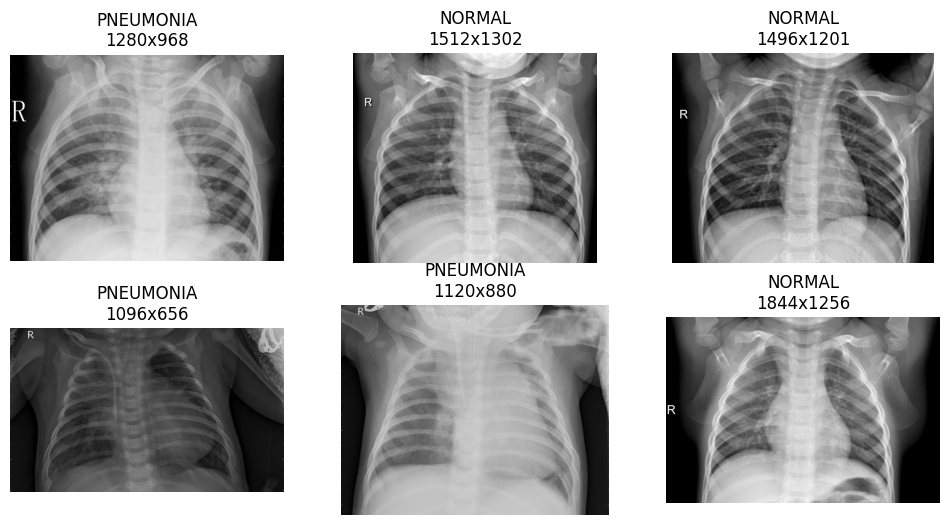

In [9]:
show_samples("/content/chest_xray_clean/train")

In [50]:
IMG_SIZE = 224
BATCH_SIZE = 32
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]
AUTOTUNE = tf.data.AUTOTUNE
train_val_dir = "/content/chest_xray_clean/train"
test_dir = "/content/chest_xray_clean/test"

In [34]:
# training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_val_dir,
    validation_split=0.1,
    subset="training",
    label_mode="binary",
    seed=21,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 5216 files belonging to 2 classes.
Using 4695 files for training.


In [51]:
# full test dataset
full_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="binary",
    class_names=CLASS_NAMES,
    shuffle=False,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# split 10% for validation
val_size = int(0.1 * len(full_test_ds))
val_ds = full_test_ds.take(val_size)
test_ds = full_test_ds.skip(val_size)

Found 624 files belonging to 2 classes.


In [52]:
# data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.08),
    tf.keras.layers.RandomZoom(0.08),
    tf.keras.layers.RandomTranslation(0.05, 0.05),
])

In [53]:
# preprocessing input to use mobilenetv2
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [54]:
# wraping the pipeloine
def prepare(ds, training=False):
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32), y), num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x,y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x,y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

train_ds = prepare(train_ds, training=True)
val_ds = prepare(val_ds, training=False)
test_ds = prepare(test_ds, training=False)

In [55]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [56]:
# handling class imbalances and sample weighting
def get_class_counts(data):
  counts = Counter()
  for _, y in data.unbatch():
    counts[int(y.numpy())] += 1
  return counts

In [57]:
counts = get_class_counts(
    tf.keras.preprocessing.image_dataset_from_directory(os.path.join(data_dir,'train'),
    label_mode='binary',
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=1,
    shuffle=False
))
print(counts)
total = sum(counts.values())
class_weight = {0: total/(2*counts[0]), 1: total/(2*counts[1])}
print('class_weight:', class_weight)

Found 5216 files belonging to 2 classes.


/tmp/ipython-input-1352065640.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  counts[int(y.numpy())] += 1


Counter({1: 3875, 0: 1341})
class_weight: {0: 1.9448173005219984, 1: 0.6730322580645162}


## modelling and training

In [58]:
# base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape = (IMG_SIZE, IMG_SIZE, 3),
    include_top = False,
    weights = "imagenet"
)
base_model.trainable = False

In [59]:
inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = inputs
x = data_augmentation(x)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [60]:
# model initialization
model = Model(inputs, outputs)

In [61]:
# model compile
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
auc = tf.keras.metrics.AUC(name="auc")
model.compile(
    optimizer = optimizer,
    loss = "binary_crossentropy",
    metrics = [
        "accuracy",
        auc
    ]
)

In [62]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,713 (9.26 MB)

 Trainable params: 166,913 (652.00 KB)

 Non-trainable params: 2,260,800 (8.62 MB)

In [63]:
# callbacks
checkpoint_path = "/content/mobilenetv2_pneumonia_best.keras"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = checkpoint_path,
        monitor = "val_auc",
        mode = "max",
        save_best_only = True,
        verbose = 1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor = "val_auc",
        mode = "max",
        patience = 8,
        restore_best_weights = True,
        verbose = 1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = "val_auc",
        mode = "max",
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

In [ ]:
# train head
history_head = model.fit(
    train_ds,
    epochs = 12,
    validation_data = val_ds,
    class_weight = class_weight,
    callbacks = callbacks
)